In [118]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils

import ImageDataset
from skimage import io, transform
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import importlib

from torch.utils.data import DataLoader
import utils
import Discriminator
import building_blocks
import model
import mask_generation
import unet_model
%matplotlib inline

In [2]:
from torchvision import models

In [4]:
resnet = models.resnet.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/dmitrii/.torch/models/resnet18-5c106cde.pth
56.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


In [3]:
d = Discriminator.GrowableDiscriminator()

In [7]:
d.grow()

In [8]:
utils.get_n_params(d)

8996065

In [5]:
utils.get_n_params(resnet)

11689512

In [119]:
image_size = 256
test_dataset = ImageDataset.ImageDataset(["../data/cityscapes/test/"],mean_color=[0.376, 0.434, 0.45],
                                         im_size=image_size, normalize=True)
mask_gen = mask_generation.MaskGenerator(img_size=image_size)

In [3]:
data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [5]:
for input_batch in data_loader:
    gt = input_batch.cuda(device=2)
    batch_size = gt.size(0)
    mask = mask_gen.generate_mask() # mask_gen.generate_mask_batch(batch_size)
    mask[mask>0]=1
    mask = mask.cuda(device=2)
    distorted = gt * (1-mask) + test_dataset.background.cuda(device=2) * mask
    distorted = torch.cat((distorted, mask.expand(batch_size, -1, -1, -1)), dim=1) #mask.expand(batch_size, -1, -1, -1)
    G_output = G_net(Variable(distorted))

    cur_gt = Variable(downsampler(gt))
    cur_mask = Variable(downsampler(mask))
    cur_mask = cur_mask.expand(batch_size, -1, -1, -1)
    neg_mask = 1-cur_mask

    pred = cur_mask*G_output + neg_mask*cur_gt
    
    break

NameError: name 'G_net' is not defined

In [60]:
def inference(g_network, sample, mask, background):
    x2_downsampler = nn.AvgPool2d(2)
    to_pil = transforms.ToPILImage()
    
#     if len(input.size()) == 3:
    distorted = sample * (1-mask) + background * mask
    input = Variable(torch.cat((distorted, mask), dim=0)).unsqueeze(0).cuda(device=2)
    g_output = g_network(input)
    g_output = mask * g_output.data[0].cpu() + (1-mask) * sample
    return g_output
#     g_output = g_network(distorted.unsqueeze(0).cuda())
#     mask = x2_downsampler(mask)
#     sample = x2_downsampler(sample)
#     pred = mask * g_output.data[0].cpu() + (1-mask) * sample
#     return pred

In [40]:
def plot_several(gt, out, mask, background):
    fig=plt.figure(figsize=(20, 8))
    to_pil = transforms.ToPILImage()
    fig.add_subplot(1, 3, 1)
    plt.imshow(to_pil(mask))
    fig.add_subplot(1, 3, 2)
    plt.imshow(to_pil(out + background))
    fig.add_subplot(1, 3, 3)
    plt.imshow(to_pil(gt + background))    

In [123]:
G_net = unet_model.GrowableUNet(4, 64, pred_level=2, levels=6).cuda(device=2)
for i in range(4):
    G_net.grow()
G_net = G_net.cuda(device=2)
G_net.load_state_dict(torch.load('model/unet_in/G_closernonlocal_moreiters_bnD_gatedconv_growable_scheduler_myunet_cs_l1_lsgan_2506_bs16_lrg5e-05_lrd4e-04_advw1e-01_gpw1e+00'))

In [124]:
G_net.alpha = 1.0

In [127]:
G_net.freeze_bn()

In [44]:
downsampler = nn.AvgPool2d(2)
to_pil = transforms.ToPILImage()

In [45]:
sample = test_dataset.__getitem__(6)

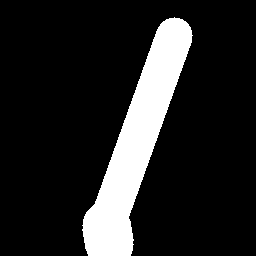

In [47]:
mask = mask_gen.generate_mask()
mask[mask>0] = 1
# mask = x2_downsampler(mask)
to_pil(mask)

In [135]:
output = inference(G_net, sample, mask, test_dataset.background)

/home/dmitrii/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


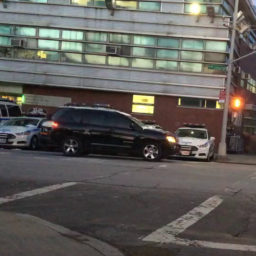

In [55]:
to_pil(sample + test_dataset.mean_color)

### With skip connections on top level

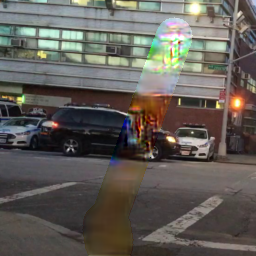

In [126]:
to_pil(torch.clamp(output + test_dataset.mean_color, 0, 1))

### No skip connections on top level

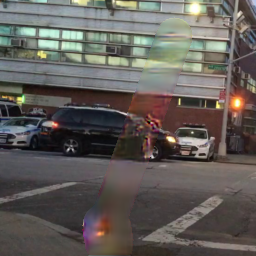

In [122]:
to_pil(torch.clamp(output + test_dataset.mean_color, 0, 1))

### No skip connections on second from top layer

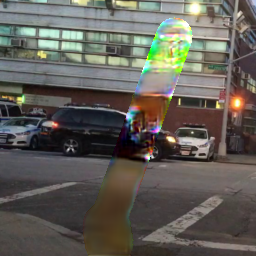

In [136]:
to_pil(torch.clamp(output + test_dataset.mean_color, 0, 1))

In [130]:
w = G_net.up_layers[3].conv.conv.soft_gating.weight.data

In [131]:
w.size()

torch.Size([128, 384, 3, 3])

In [132]:
w[:,-128:,:,:] = torch.zeros(128,128,3,3)

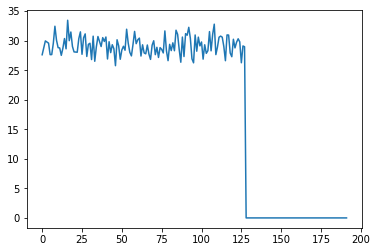

In [133]:
plt.plot(w.permute(1, 0, 2, 3).contiguous().view(192,-1).abs().sum(1).cpu().numpy())

In [134]:
G_net.up_layers[3].conv.conv.soft_gating.weight.data = w

In [120]:
outputs = inference(G_net, sample, mask, test_dataset.background)

/home/dmitrii/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


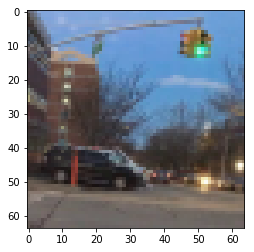

In [90]:
plt.imshow(transforms.ToPILImage()(x2_downsampler(x2_downsampler(Variable(sample+1)/2)).data))

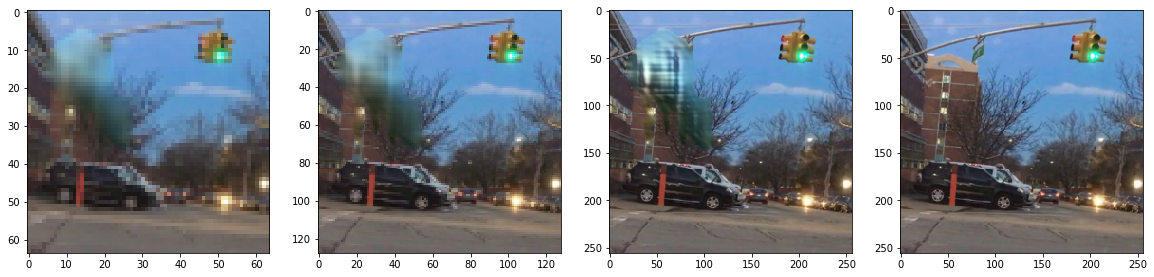

In [97]:
plot_several((sample+1)/2, outputs)

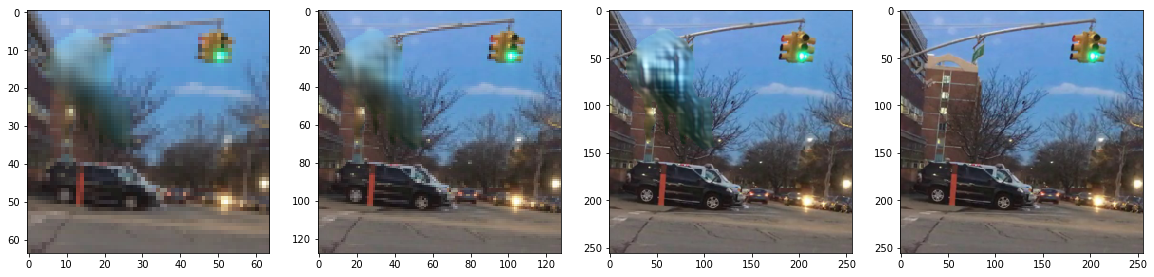

In [91]:
plot_several((sample+1)/2, outputs)

In [48]:
for i in range(50):
    sample = test_dataset.__getitem__(i)
    mask, x, y = mask_gen.generate_mask()
    mask[mask>0] = 1
    outputs = inference(lap_G, sample, mask, test_dataset.background)
    sample = Variable(sample)
    to_pil(mask).save(f"../data/sr_inp/{i}_mask.png")
    for lvl in range(len(outputs)):
        to_pil(sample.data).save(f"../data/sr_inp/{i}_gt_{lvl}.png")
        if lvl!= len(outputs)-1:
            sample = x2_downsampler(sample)
        to_pil(outputs[lvl]).save(f"../data/sr_inp/{i}_pred_{lvl}.png")
        

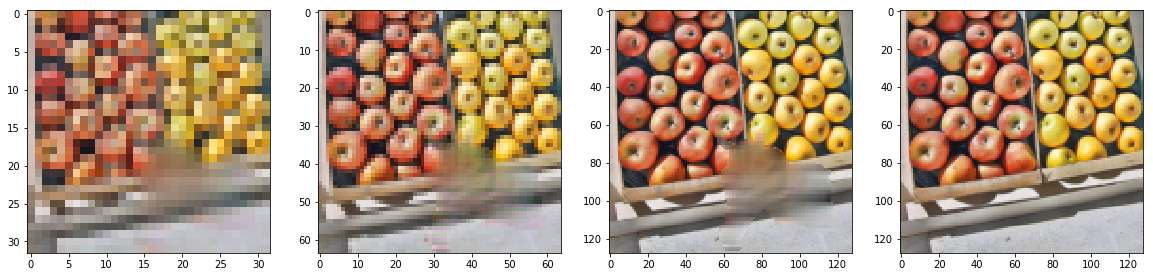

In [24]:
plot_several(sample, outputs)

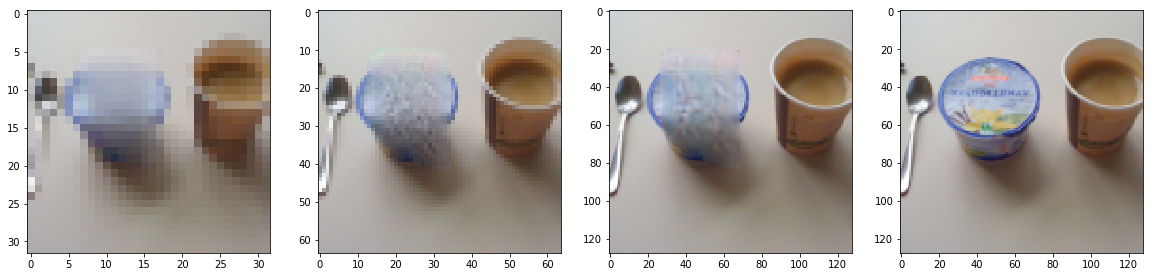

In [203]:
plot_several(sample, outputs)

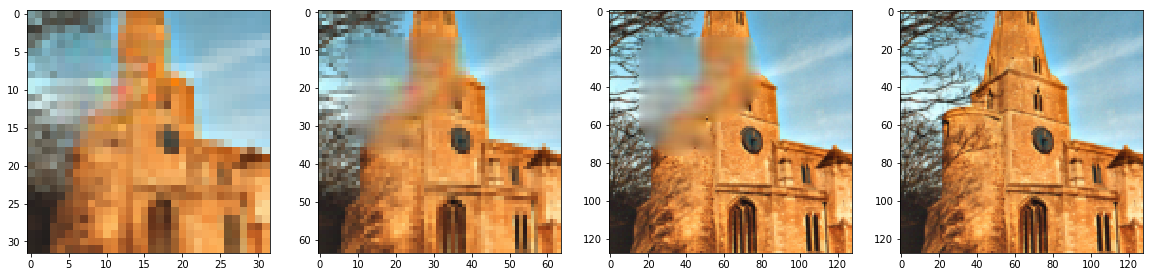

In [124]:
plot_several(sample, outputs)

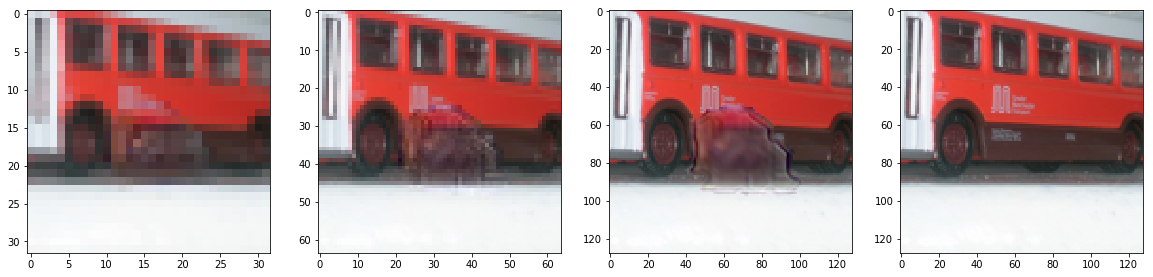

In [154]:
plot_several(sample, outputs)

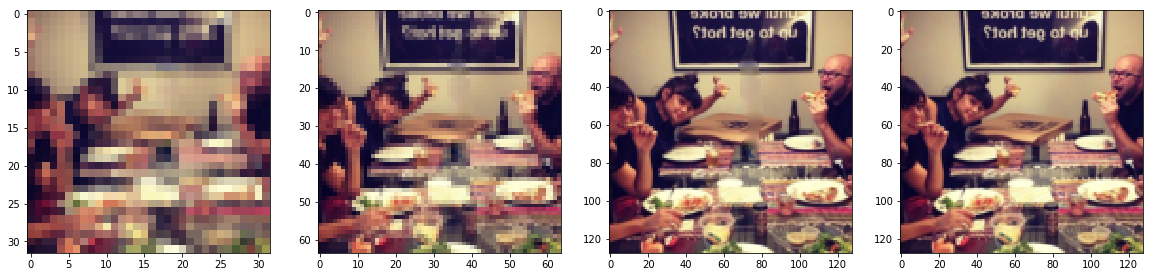

In [187]:
plot_several(sample['gt'], outputs)

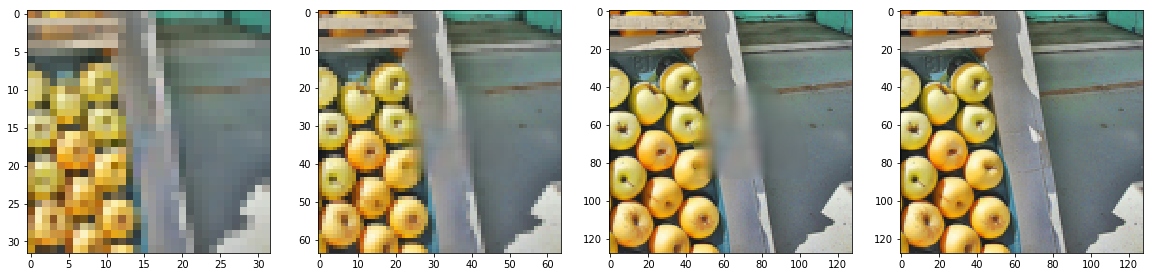

In [37]:
plot_several(sample['gt'], outputs)

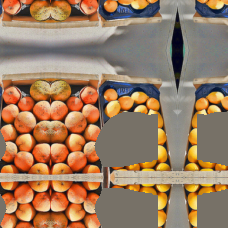

In [18]:
padded = F.pad(sample['distorted'].unsqueeze(0), (50, 50, 50, 50), mode='reflect')
transforms.ToPILImage()(padded.data[0])